device: cuda
set transforms for each dataset
initialize datasets
dataset HockeyFights
fold 0
create model
epoch 0
training
800
25
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
train loss: 0.5294970846176148
evaluating
200
7
batch
batch
batch
batch
batch
batch
batch
val loss: 0.595593912260873
epoch 1
training
800
25
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
train loss: 0.382982491850853
evaluating
200
7
batch
batch
batch
batch
batch
batch
batch
val loss: 0.3725690117904118
epoch 2
training
800
25
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
train loss: 0.39166474640369414
evaluating
200
7
batch
batch
batch
batch
batch
batch
batch
val loss: 0.39569241234234404


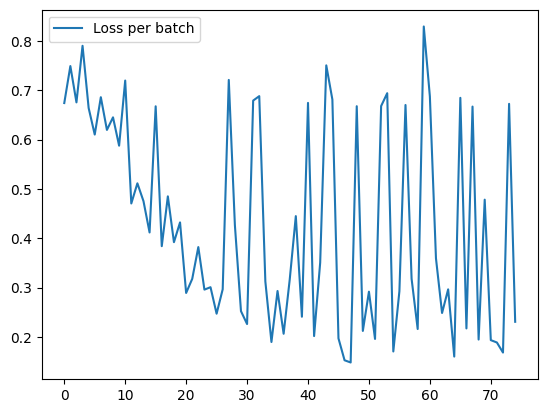

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import wandb
from torch.nn import BCELoss
from torch.optim import Adam
from torch.utils import data

from data_handling.data_augmentation import VideoTransform
from data_handling.video_dataset import VideoDataset
from model.violence_detection_model import ViolenceDetectionModel
from utils import collate_fn_pad


config = {
    "lr": 0.00009535,
    "epochs": 3,
    "factor": 0.1,
    "batch": 32,
    "n_folds": 5,
}

def train():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print("device: {}".format(device))

    print("set transforms for each dataset")
    hf_transforms = VideoTransform(dataset="HockeyFights", json_file="augmentation_values.json")

    print("initialize datasets")
    hf_dataset = VideoDataset(dataset="HockeyFights", transformations=hf_transforms)
    
    # helper list for calculating the final val_loss
    val_losses = []

    for dataset in [hf_dataset]:
        print("dataset {}".format(dataset.dataset))

        for n, fold in enumerate(dataset.k_fold(n_folds=config["n_folds"])):
            print("fold {}".format(n))
            dataloader = data.DataLoader(fold, batch_size=config["batch"], collate_fn=collate_fn_pad, shuffle=True)

            print("create model")
            vd_model = ViolenceDetectionModel(json_file="model_settings.json")
            vd_model = vd_model.to(device)

            criterion = BCELoss()
            optimizer = Adam(params=vd_model.parameters(), lr=config["lr"])
            scheduler = StepLR(optimizer=optimizer, step_size=2, gamma=config["factor"])
            # scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=wandb.config.factor, patience=0)

            # track losses per batch in training along epochs
            losses_per_batch = np.array([])

            for epoch in range(config["epochs"]):
                print("epoch {}".format(epoch))

                # ------------train------------
                print("training")

                vd_model.train()
                # use training part of dataset
                fold.flag = False

                # track loss for entire train dataset
                cumulating_loss = 0.0

                print(len(fold))
                print(len(dataloader))
                for batch in dataloader:
                    print("batch")
                    optimizer.zero_grad()

                    videos, labels, lengths = batch
                    videos, labels = videos.to(device), labels.to(device)

                    outputs = vd_model(videos, lengths)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    losses_per_batch = np.append(losses_per_batch, loss.detach().cpu().item())
                    cumulating_loss += loss.cpu().item()

                # log the cumulating train loss to wandb
                avg_loss = cumulating_loss / len(dataloader)
                print("train loss: {}".format(avg_loss))

                scheduler.step()
                # ------------val------------
                print("evaluating")

                vd_model.eval()
                fold.flag = True

                # lists for tracking loss and f1 for the entire val dataset
                cumulating_loss = 0.0
                cumulating_outputs = []
                cumulating_labels = []

                print(len(fold))
                print(len(dataloader))
                for batch in dataloader:
                    print("batch")
                    videos, labels, lengths = batch
                    videos, labels = videos.to(device), labels.to(device)

                    outputs = vd_model(videos, lengths)
                    loss = criterion(outputs, labels)

                    cumulating_loss += loss.cpu().item()
                    cumulating_outputs.extend(outputs.cpu().tolist())
                    cumulating_labels.extend(labels.cpu().tolist())

                avg_loss = cumulating_loss / len(dataloader)
                print("val loss: {}".format(avg_loss))

                val_losses.append(avg_loss)

            fig, ax = plt.subplots()
            ax.plot(losses_per_batch, label="Loss per batch")
            ax.legend()
            plt.show()
            plt.close(fig)

            break  # fold

train()
